# Creating and Pushing a Classifer Into Production with FastAI

note: when running this in colab, remember to set runtime to use a gpu!

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

/home/gg-pc/anaconda3/lib/python3.8/site-packages/fastbook/__init__.py:22: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

In line with my work creating an ecosystem building game which helps kids & adults of all ages get familiar with local flora and fauna, I'm going to build a poison ivy classifier. 

### Starting My Project

I took the advice of the course and kept in mind that:
"[...] the the most important consideration is data availability. The goal is not to find the "perfect" dataset or project, but just to get started and iterate from there."


### The Drivetrain Approach

There are many accurate models that are of no use to anyone, and many inaccurate models that are highly useful. To ensure that your modeling work is useful in practice, you need to consider how your work will be used. In 2012 Jeremy, along with Margit Zwemer and Mike Loukides, introduced a method called *the Drivetrain Approach* for thinking about this issue.

The Drivetrain Approach, illustrated in <<drivetrain>>, was described in detail in ["Designing Great Data Products"](https://www.oreilly.com/radar/drivetrain-approach-data-products/). The basic idea is to start with considering your objective, then think about what actions you can take to meet that objective and what data you have (or can acquire) that can help, and then build a model that you can use to determine the best actions to take to get the best results in terms of your objective.

<img src="https://github.com/ephemeralwaves/fastbook/blob/master/images/drivetrain-approach.png?raw=1" id="drivetrain" caption="The Drivetrain Approach">

* Objective: Identify images of poison ivy when uploading a picture of a plant found in the wild.
* Levers(what actions you can take): What sorts of data make it into the set, ie using poison ivy and look alikes so the model can distinguish
* Data: Images of known poison ivy plants and look alikes. Datasets must include leaves, flowers, roots.

Only after these first three steps do we begin thinking about building the predictive *models*. Our objective and available levers, what data we already have and what additional data we will need to collect, determine the models we can build. The models will take both the levers and any uncontrollable variables as their inputs; the outputs from the models can be combined to predict the final state for our objective.

* Model: Shows probability it is poison ivy or not
and always recommends you stay away if you're not sure ;)

## Gathering Data

For many types of projects, you may be able to find all the data you need online. The project we'll be completing in this chapter is a *poison ivy detector*. It will discriminate between these types of plants: poison ivy, japenese kudzu,aromatic sumac, boxelder, Boston ivy, and Virginia creeper. 

I will be using Bing Image Search/Azure Cognitive Services.


# Search
To download images with Bing Image Search, I signed up at Microsoft. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):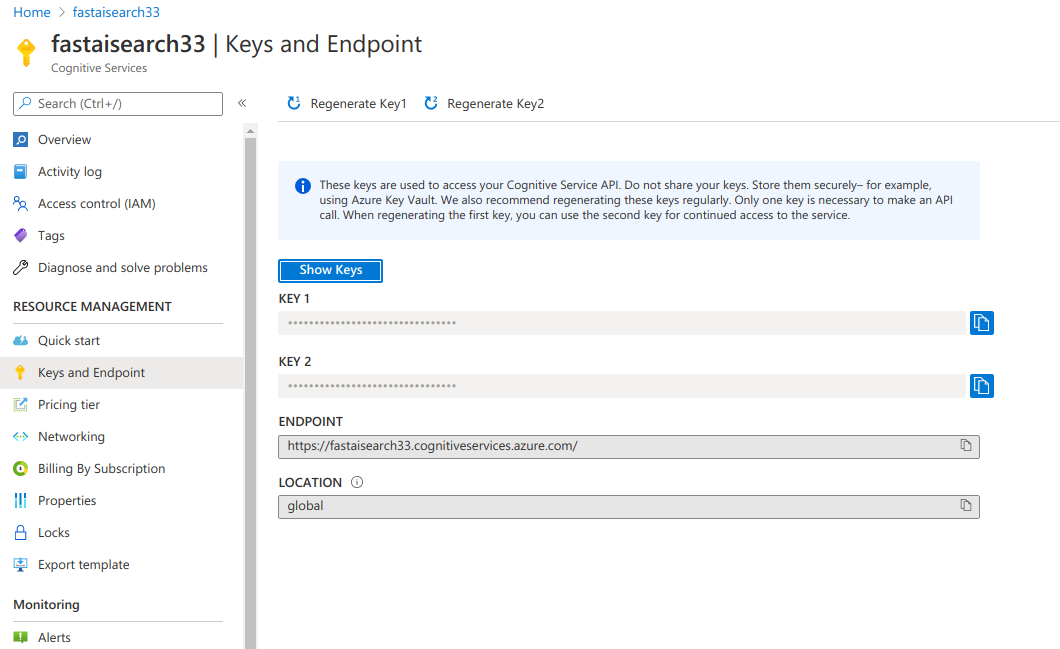

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'xxx')

Or, if you're comfortable at the command line, you can set it in your terminal with:

    export AZURE_SEARCH_KEY=your_key_here

and then restart Jupyter Notebook, and use the above line without editing it.

Once you've set `key`, you can use `search_images_bing`. This function is provided by the small `utils` class included with the notebooks online. If you're not sure where a function is defined, you can just type it in your notebook to find out:

In [5]:
search_images_bing

<function fastbook.search_images_bing>

In [6]:
results = search_images_bing(key, 'Poison Ivy leaves plants')
ims = results.attrgot('content_url')
len(ims)

150

In [7]:
print(ims[3])

https://bygl.osu.edu/sites/default/files/field/image/poison_ivy_as.jpg


We've successfully downloaded the URLs of 150 poison ivy plants (or, at least, images that Bing Image Search finds for that search term). Let's look at one:

In [8]:
os.mkdir("images/")
dest = 'images/poisonivy.jpg'
download_url(ims[0], dest)

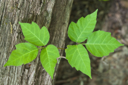

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

This seems to have worked nicely, so let's use fastai's `download_images` to download all the URLs for each of our search terms. We'll put each in a separate folder:

In [11]:
plant_types = 'poison ivy', 'virginia creeper', 'kudzu', 'aromatic sumac', 'boxelder', 'boston ivy'
path = Path('plants')

In [ ]:

try:
    path.mkdir()
except FileExistsError:
    pass
for o in plant_types:
      dest = (path/o)
      dest.mkdir(exist_ok=True)
      results = search_images_bing(key, f'{o} leaves leaf')
      download_images(dest, urls=results.attrgot('content_url'))

Our folder has image files, as we'd expect:

In [12]:
fns = get_image_files(path)
fns

(#785) [Path('/content/gdrive/My Drive/datasets/plants/boxelder/00000000.jpg'),Path('/content/gdrive/My Drive/datasets/plants/boxelder/00000001.JPG'),Path('/content/gdrive/My Drive/datasets/plants/boxelder/00000006.jpg'),Path('/content/gdrive/My Drive/datasets/plants/boxelder/00000003.jpg'),Path('/content/gdrive/My Drive/datasets/plants/boxelder/00000005.jpg'),Path('/content/gdrive/My Drive/datasets/plants/boxelder/00000002.jpg'),Path('/content/gdrive/My Drive/datasets/plants/boxelder/00000018.jpg'),Path('/content/gdrive/My Drive/datasets/plants/boxelder/00000014.jpg'),Path('/content/gdrive/My Drive/datasets/plants/boxelder/00000009.jpg'),Path('/content/gdrive/My Drive/datasets/plants/boxelder/00000016.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [13]:
failed = verify_images(fns)
failed

(#0) []

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [ ]:
failed.map(Path.unlink);

Now that we have downloaded some data, we need to assemble it in a format suitable for model training. In fastai, that means creating an object called `DataLoaders`.

# Uploading a dataset


For this particular problem, identifying poison ivy, pulling from bing image search lead to a lot of mistakes in the data since poison ivy is easily mistaken for the other plants we are training the model to recognize.
So I ran the code above locally and curated it before uploading since using Colab was a pain in terms of curation.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
plant_types = 'poison ivy', 'virginia creeper', 'kudzu', 'aromatic sumac', 'boxelder', 'boston ivy'
path = Path('/content/gdrive/My Drive/datasets/plants')

## From Data to DataLoaders

> jargon: DataLoaders: A fastai class that stores multiple `DataLoader` objects you pass to it, normally a `train` and a `valid`, although it's possible to have as many as you like. The first two are made available as properties.


To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

So far we have seen a number of *factory methods* for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the *data block API*. With this API you can fully customize every stage of the creation of your `DataLoaders`. Here is what we need to create a `DataLoaders` for the dataset that we just downloaded:

In [5]:
plants = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Let's look at each of these arguments in turn. First we provide a tuple where we specify what types we want for the independent and dependent variables: 

```python
blocks=(ImageBlock, CategoryBlock)
```

The *independent variable* is the thing we are using to make predictions from, and the *dependent variable* is our target. In this case, our independent variables are images, and our dependent variables are the categories (type of plant) for each image. 

For this `DataLoaders` our underlying items will be file paths. We have to tell fastai how to get a list of those files. The `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, by default):

```python
get_items=get_image_files
```

Often, datasets that you download will already have a validation set defined. Sometimes this is done by placing the images for the training and validation sets into different folders. Sometimes it is done by providing a CSV file in which each filename is listed along with which dataset it should be in. There are many ways that this can be done, and fastai provides a very general approach that allows you to use one of its predefined classes for this, or to write your own. In this case, however, we simply want to split our training and validation sets randomly. However, we would like to have the same training/validation split each time we run this notebook, so we fix the random seed (computers don't really know how to create random numbers at all, but simply create lists of numbers that look random; if you provide the same starting point for that list each time—called the *seed*—then you will get the exact same list each time):


```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```

The independent variable is often referred to as `x` and the dependent variable is often referred to as `y`. Here, we are telling fastai what function to call to create the labels in our dataset:

```python
get_y=parent_label
```

`parent_label` is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a *mini-batch*). To group them in a big array (usually called a *tensor*) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. *Item transforms* are pieces of code that run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we use the `Resize` transform here:

```python
item_tfms=Resize(128)
```

This command has given us a `DataBlock` object. This is like a *template* for creating a `DataLoaders`. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [15]:
dls = plants.dataloaders(path)

A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

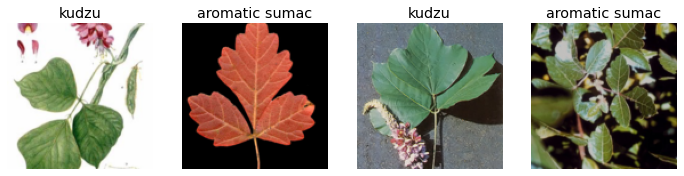

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

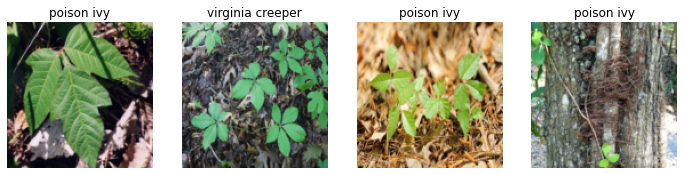

In [ ]:
plants = plants.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = plants.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

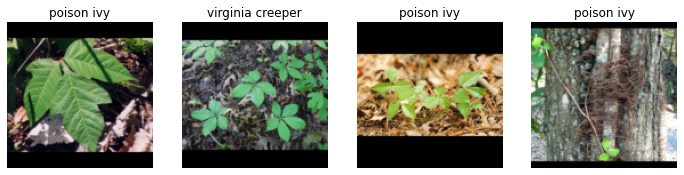

In [ ]:
plants = plants.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = plants.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace `Resize` with `RandomResizedCrop`, which is the transform that provides the behavior we just described. The most important parameter to pass in is `min_scale`, which determines how much of the image to select at minimum each time:

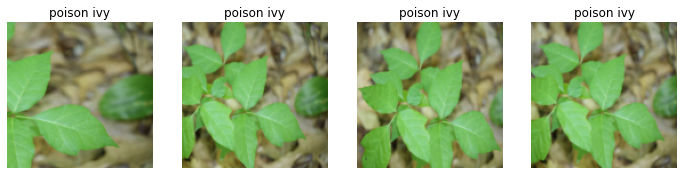

In [ ]:
plants = plants.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = plants.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

We used `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

### Data Augmentation

*Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter (note that we're not using `RandomResizedCrop` in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

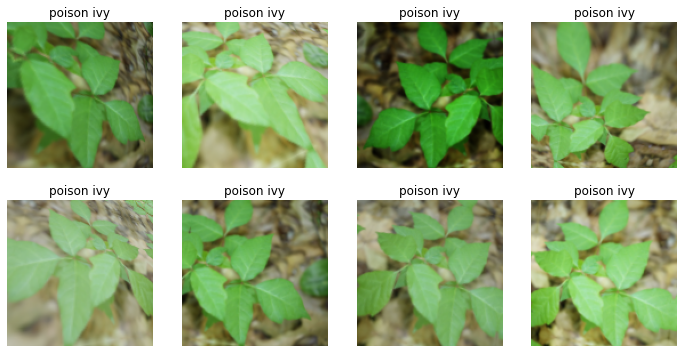

In [ ]:
plants = plants.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = plants.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training Your Model, and Using It to Clean Your Data

Time to use the same lines of code as in <<chapter_intro>> to train our plant classifier.

We don't have a lot of data for our problem (150 pictures of each sort of plant at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [17]:
plants = plants.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = plants.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [18]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Now let's see whether the mistakes the model is making are mainly thinking that virginia creepers are poison ivy or that poison ivy are boston ivy, or something else. To visualize this, we can create a *confusion matrix*:

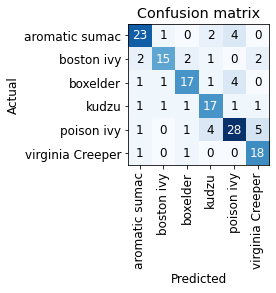

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

 With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue. 

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't plants at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

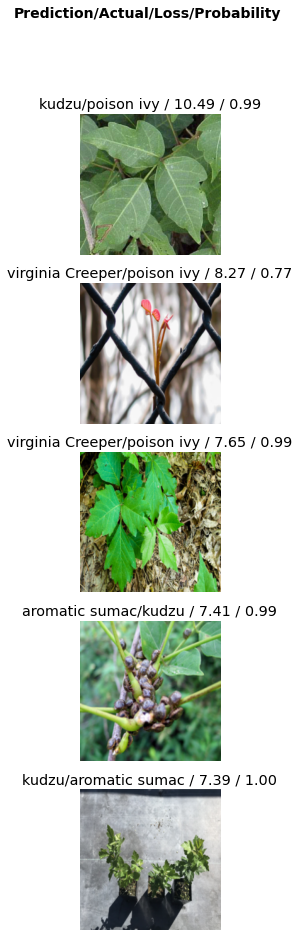

In [20]:
interp.plot_top_losses(5, nrows=5)



The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [21]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()


In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now that we have trained our model, let's see how we can deploy it to be used in practice.

## Turning Your Model into an Online Application

We are now going to look at what it takes to turn this model into a working online application. We will just go as far as creating a basic working prototype; we do not have the scope in this book to teach you all the details of web application development generally.

### Using the Model for Inference

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [22]:
learn.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [23]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [9]:
learn_inf = load_learner(path/'export.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [ ]:
learn_inf.predict('images/poisonivy.jpg')

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [11]:
learn_inf.dls.vocab

(#6) ['aromatic sumac','boston ivy','boxelder','kudzu','poison ivy','virginia Creeper']

### Creating a Notebook App from the Model

To use our model in an application, we can simply treat the `predict` method as a regular function. Therefore, creating an app from the model can be done using any of the myriad of frameworks and techniques available to application developers.

However, most data scientists are not familiar with the world of web application development. So let's try using something that you do, at this point, know: it turns out that we can create a complete working web application using nothing but Jupyter notebooks! The two things we need to make this happen are:

- IPython widgets (ipywidgets)
- Voilà

*IPython widgets* are GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook. For instance, the image cleaner that we saw earlier in this chapter is entirely written with IPython widgets. However, we don't want to require users of our application to run Jupyter themselves.

That is why *Voilà* exists. It is a system for making applications consisting of IPython widgets available to end users, without them having to use Jupyter at all. Voilà is taking advantage of the fact that a notebook _already is_ a kind of web application, just a rather complex one that depends on another web application: Jupyter itself. Essentially, it helps us automatically convert the complex web application we've already implicitly made (the notebook) into a simpler, easier-to-deploy web application, which functions like a normal web application rather than like a notebook.

But we still have the advantage of developing in a notebook, so with ipywidgets, we can build up our GUI step by step. We will use this approach to create a simple image classifier. First, we need a file upload widget:

In [12]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" src="https://github.com/ephemeralwaves/fastbook/blob/master/images/att_00008.png?raw=1">

Now we can grab the image:

In [13]:
img = PILImage.create(btn_upload.data[-1])

We can use an `Output` widget to display it:

In [14]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [15]:
pred,pred_idx,probs = learn_inf.predict(img)

and use a `Label` to display them:

In [16]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: virginia Creeper; Probability: 0.8220')

`Prediction: poison ivy; Probability: .9997`

We'll need a button to do the classification. It looks exactly like the upload button:

In [17]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

We'll also need a *click event handler*; that is, a function that will be called when it's pressed. We can just copy over the lines of code from above:

In [18]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

You can test the button now by pressing it, and you should see the image and predictions update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [19]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [20]:
#hide_output
VBox([widgets.Label('Select your plant!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable voila —sys-prefix

Now that we have everything working in this Jupyter notebook, we can create our application. To do this, start a new notebook and add to it only the code needed to create and show the widgets that you need, and markdown for any text that you want to appear. 

Next, install Voilà if you haven't already, by copying these lines into a notebook cell and executing it:

    !pip install voila
    !jupyter serverextension enable voila —sys-prefix

Cells that begin with a `!` do not contain Python code, but instead contain code that is passed to your shell (bash, Windows PowerShell, etc.). If you are comfortable using the command line, which we'll discuss more later in this book, you can of course simply type these two lines (without the `!` prefix) directly into your terminal. In this case, the first line installs the `voila` library and application, and the second connects it to your existing Jupyter notebook.

Voilà runs Jupyter notebooks just like the Jupyter notebook server you are using now does, but it also does something very important: it removes all of the cell inputs, and only shows output (including ipywidgets), along with your markdown cells. So what's left is a web application! To view your notebook as a Voilà web application, replace the word "notebooks" in your browser's URL with: "voila/render". You will see the same content as your notebook, but without any of the code cells.

Of course, you don't need to use Voilà or ipywidgets. Your model is just a function you can call (`pred,pred_idx,probs = learn.predict(img)`), so you can use it with any framework, hosted on any platform. And you can take something you've prototyped in ipywidgets and Voilà and later convert it into a regular web application. We're showing you this approach in the book because we think it's a great way for data scientists and other folks that aren't web development experts to create applications from their models.

We have our app, now let's deploy it!

### Deploying the app

For at least the initial prototype of your application, and for any hobby projects that you want to show off, you can easily host them for free. The best place and the best way to do this will vary over time, so check the [book's website](https://book.fast.ai/) for the most up-to-date recommendations. As we're writing this book in early 2020 the simplest (and free!) approach is to use [Binder](https://mybinder.org/). To publish your web app on Binder, you follow these steps:

1. Add your notebook to a [GitHub repository](http://github.com/).
2. Paste the URL of that repo into Binder's URL, as shown in <<deploy-binder>>.
3. Change the File dropdown to instead select URL.
4. In the "URL to open" field, enter `/voila/render/name.ipynb` (replacing `name` with the name of for your notebook).
5. Click the clickboard button at the bottom right to copyt the URL and paste it somewhere safe. 
6. Click Launch.

<img alt="Deploying to Binder" width="800" caption="Deploying to Binder" id="deploy-binder" src="https://github.com/ephemeralwaves/fastbook/blob/master/images/att_00001.png?raw=1">

## Further Research

The model is limited with the data I trained it with, so for instance if I show it a picture of daisies it will try to fit it into one of the categories it knows. It was also suprising that it tends to mix up Virginia creeper up with poison ivy since by human standards it's easy to tell them apart by counting the number of leaves. Of course it has no notion of what a leaf is so I'm guessing that's why. 

If I'm to iterate over this project again I'd probably try to incorporate more transfer learning by finding a model that has been trained to recognize a plant data set such as (https://www.kaggle.com/apollonius/usda-plant-database) or something like this. 